In [1]:
#!pip install einops

In [2]:
import torch
from torch import nn
from einops import rearrange

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler,autocast
import torch.optim as optim

import sys
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split

/tmp/ipykernel_90962/3799284888.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
root_path = r"/home/srikanth/Dataset/RGB_images"
dataset_path = os.listdir(root_path)

DATASET AND DATALOADER

In [5]:
class_labels = []

for item in dataset_path:
    #print(item)
    all_objects = os.listdir(root_path + '/' +item)
    for top_object in all_objects:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            images = os.listdir(root_path + '/' +item + '/' +top_object + '/' +sub_object)
            for image in images:
                class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object +'/' +image)))
            
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [6]:
# class_labels = []

# for item in dataset_path:
#     #print(item)
#     all_objects = os.listdir(root_path + '/' +item)
#     for top_object in all_objects:
#         sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
#         for sub_object in sub_objects:
#             images = os.listdir(root_path + '/' +item + '/' +top_object + '/' +sub_object)
#             for image in images:
#                 class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object +'/' +image)))

# df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
# y=list(df['labels'].values)
# image=df['image']

In [7]:
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.2, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [8]:
classes=list(train_df['labels'].unique())
class_count=len(classes)

In [9]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [10]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((49, 49), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)
    
    def calculate_resize_value(self, input_size):
        return int((256 / 224) * input_size)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [11]:
# Create dataset objects
train_dataset = ImageDataset(train_df, transform=transforms)
val_dataset = ImageDataset(valid_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

In [12]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

MODEL

In [13]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x



In [14]:
class CViT(nn.Module):
    def __init__(self, image_size=49, patch_size=7, num_classes=4, channels=3,
                 dim=1024, depth=6, heads=8, mlp_dim=2048):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding = 1),   #changed stride 2 to 1

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),   #changed stride 2 to 1

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted stride from 2 to 1

        )

        num_patches = (7 // patch_size) ** 2
        patch_dim = 512 * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(32, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = self.features(img)
        #print(x.shape)
        y = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        y = self.patch_to_embedding(y)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, y), 1)
        #batch_size = x.shape[0]
        #expanded_pos_embedding = self.pos_embedding[:batch_size]
        shape=x.shape[0]
        #x = torch.cat((cls_tokens, y), 1)
        #x += expanded_pos_embedding
        x += self.pos_embedding[0:shape]
        x = self.transformer(x, mask)
        x = self.to_cls_token(x[:, 0])

        return self.mlp_head(x)

In [15]:
# Initialize your model, optimizer, and loss function
model = CViT(image_size=49, patch_size=7, num_classes=4, channels=512,
            dim=1024, depth=6, heads=8, mlp_dim=2048)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 40

# Initialize the GradScaler for mixed precision training
#scaler = GradScaler()

In [16]:
model

CViT(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [17]:
from tqdm import tqdm

def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
    best_acc = 0.0
    min_loss = min_val_loss

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Using tqdm for progress tracking
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update the learning rate
        # scheduler.step()  # Uncomment if using a learning rate scheduler

        # Save the model if it has the best validation accuracy so far
        # if epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     state = {
        #         'epoch': epoch + 1,
        #         'state_dict': model.state_dict(),
        #         'optimizer': optimizer.state_dict(),
        #         'min_loss': epoch_loss
        #     }
        # torch.save(state, 'weight/cvit_deepfake_detection_v2.pth')

    return train_losses, train_accs, val_losses, val_accs, min_loss

In [18]:
# def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
#     best_acc = 0.0
#     min_loss = min_val_loss

#     train_losses = []
#     train_accs = []
#     val_losses = []
#     val_accs = []

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)
#         model.train()  # Set model to training mode
#         running_loss = 0.0
#         running_corrects = 0
#         phase_idx = 0

#         # Iterate over data.
#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(True):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 # backward + optimize only if in training phase
#                 loss.backward()
#                 optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             if phase_idx % 100 == 0:
#                 print(f'Train Epoch: {epoch} [{phase_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * phase_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
#             phase_idx += 1

#         epoch_loss = running_loss / len(train_loader.dataset)
#         epoch_acc = running_corrects.double() / len(train_loader.dataset)

#         train_losses.append(epoch_loss)
#         train_accs.append(epoch_acc)
#         print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         # Validation phase
#         model.eval()  # Set model to evaluate mode
#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             with torch.no_grad():
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(val_loader.dataset)
#         epoch_acc = running_corrects.double() / len(val_loader.dataset)

#         val_losses.append(epoch_loss)
#         val_accs.append(epoch_acc)
#         print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         # Update the learning rate
#         # scheduler.step()  # Uncomment if using a learning rate scheduler

#         # Save the model if it has the best validation accuracy so far
#         # if epoch_acc > best_acc:
#         #     best_acc = epoch_acc
#         #     state = {
#         #         'epoch': epoch + 1,
#         #         'state_dict': model.state_dict(),
#         #         'optimizer': optimizer.state_dict(),
#         #         'min_loss': epoch_loss
#         #     }
#         #torch.save(state, 'weight/cvit_deepfake_detection_v2.pth')

#     return train_losses, train_accs, val_losses, val_accs, min_loss



In [19]:
# Define the initial minimum validation loss
min_val_loss = float('inf')

# Call the training function with the appropriate data loaders
train_losses, train_accs, val_losses, val_accs, min_loss = trainVal(
    model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device
)

Epoch 0/39
----------


Epoch 0:  53%|█████▎    | 5359/10102 [07:24<06:40, 11.84it/s]

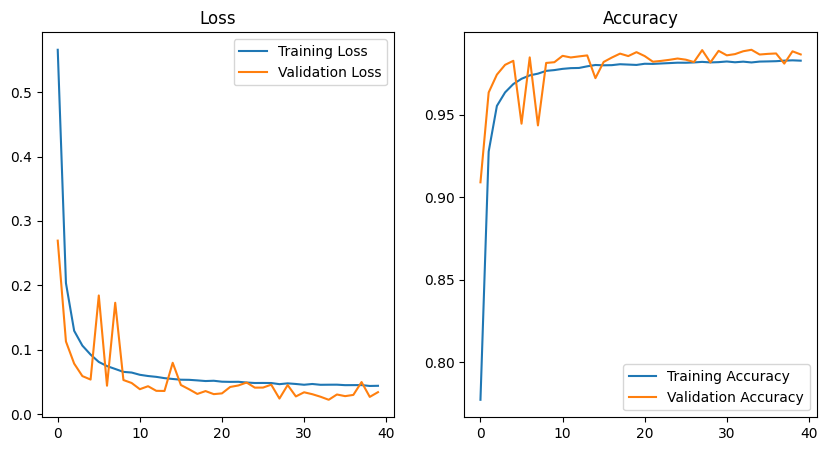

In [ ]:
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays

train_losses = torch.tensor(train_losses)
val_losses = torch.tensor(val_losses)
train_accs = torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
# TESTING
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item() * images.size(0)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))

Test Accuracy: 98.71%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[6338    3   12    3]
 [   2 3870   14    0]
 [  61    1 6940    3]
 [ 150    0   12 2795]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6356
           1       1.00      1.00      1.00      3886
           2       0.99      0.99      0.99      7005
           3       1.00      0.95      0.97      2957

    accuracy                           0.99     20204
   macro avg       0.99      0.98      0.99     20204
weighted avg       0.99      0.99      0.99     20204



In [ ]:
import pickle
# Store the data in a dictionary
data = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_losses': test_losses,
    'test_accs': test_accuracies
}

# Save the data into a pickle file
with open('CVITwwcRgb.pkl','wb') as f:
    pickle.dump(data,f)

----------------------DONE-------------------------